In [2746]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

datasource = pq.read_table("escooter_history.parquet")

dataset = datasource.to_pandas()
dataset = dataset[dataset.humidity!= 0]
dataset['windspeed'].replace(to_replace=0.0, method='bfill', inplace=True)
dataset

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered_customer
0,2019-01-01 00:00:09,0,0,"clear, few clouds",9.84,14.395,81,6.0032,True
1,2019-01-01 00:00:41,0,0,"clear, few clouds",9.84,14.395,81,6.0032,True
2,2019-01-01 00:01:20,0,0,"clear, few clouds",9.84,14.395,81,6.0032,True
3,2019-01-01 00:04:12,0,0,"clear, few clouds",9.84,14.395,81,6.0032,True
4,2019-01-01 00:15:19,0,0,"clear, few clouds",9.84,14.395,81,6.0032,True
...,...,...,...,...,...,...,...,...,...
3296016,2020-12-31 23:55:56,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True
3296017,2020-12-31 23:55:59,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True
3296018,2020-12-31 23:57:17,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True
3296019,2020-12-31 23:57:28,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True


## Größe des ursprünglichen Datensatzes

In [2747]:
dataset.shape

(3295398, 9)

In [2748]:
dataset['weather'].unique()

array(['clear, few clouds', 'cloudy, mist',
       'light snow or rain or thunderstorm',
       'heacy rain or thunderstorm or snow or ice pallets'], dtype=object)

# Daten in Stundenblöcke gruppieren

In [2749]:


hourly_dataset = dataset.resample('H', on="datetime").agg({
    'registered_customer': ['count'],
    'temp': ['mean'],
    #'atemp': ['mean'],
    #'weather': ['first'],
    'humidity': ['mean'],
    'windspeed': ['mean'],
    'holiday': ['first'],
    'workingday': ['first']
})
hourly_dataset.columns = hourly_dataset.columns.droplevel(1)
hourly_dataset.rename({'registered_customer': 'count'}, axis=1, inplace=True)
#hourly_dataset.drop('Weekday')
hourly_dataset.head(2)

,count,temp,humidity,windspeed,holiday,workingday
datetime,,,,,,
2019-01-01 00:00:00,16,9.84,81.0,6.0032,0.0,0.0
2019-01-01 01:00:00,40,9.02,80.0,6.0032,0.0,0.0


In [2750]:
hourly_dataset.isnull().values.any()
hourly_dataset.dropna(inplace=True)


## Größe des Datensatzes nach Gruppierung

In [2751]:
hourly_dataset.shape

(17357, 6)

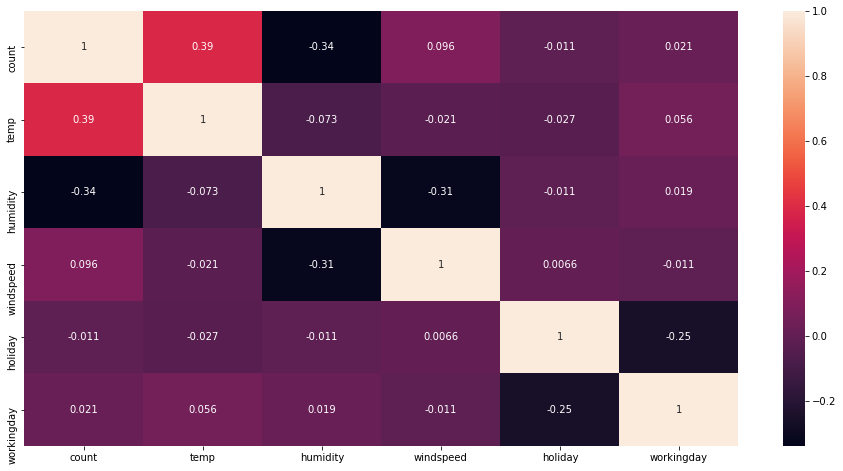

In [2752]:
plt.figure(figsize=(16,8))
sns.heatmap(hourly_dataset.corr(), annot=True)
plt.show()

## Encode Data


In [2753]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Kategorische Features die encoded werden sollen
cat_features = ['weekday', 'month', 'day', 'hour', ]#'weather']
encoder = ColumnTransformer(
    [('OHE', OneHotEncoder(),cat_features)],
    remainder = 'passthrough'
    )
def augment_date_information(dataset_input):
    dataset_in = dataset_input.copy()
    #dataset_in.set_index('datetime')
    dataset_in['weekday'] = dataset_in.index.dayofweek
    dataset_in['year'] = dataset_in.index.year
    dataset_in['month'] = dataset_in.index.month
    dataset_in['day'] = dataset_in.index.day
    dataset_in['hour'] = dataset_in.index.hour
    return dataset_in


hourly_dataset = augment_date_information(hourly_dataset)


# function necessary for later prediction
def encode_for_regression(dataset_input):
    dataset_in = dataset_input.copy()
    encoder.fit_transform(dataset_in)
    #print(dataset_in.describe())

    for cat_feature in cat_features:
        tmp_encoded = pd.get_dummies(dataset_in[str(cat_feature)], prefix=cat_feature)
        dataset_in = dataset_in.join(tmp_encoded)
        dataset_in.drop([cat_feature], axis=1, inplace=True)
    return dataset_in

labels = hourly_dataset['count']
hourly_dataset.drop(columns="count", inplace=True)
hourly_dataset = encode_for_regression(hourly_dataset)
hourly_dataset = hourly_dataset.join(labels)

# Split Training - Test



In [2754]:
from sklearn.model_selection import train_test_split
hourly_dataset = hourly_dataset.reset_index()
hourly_dataset = hourly_dataset.drop(columns=['datetime'], axis=1)

X = hourly_dataset.drop(columns=['count'], axis=1)
y = hourly_dataset['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)


# Simple Linear Regression


In [2755]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics


lr = LinearRegression()
lr.fit(X_train, y_train)


plt.figure(figsize = (18,4))
coeff = pd.DataFrame(lr.coef_, index = X.columns, columns = ['Coefficient'])
coeff = coeff.iloc[0:30]
#print(coeff)


<Figure size 1296x288 with 0 Axes>

## Interpretation der Koeffizienten

<AxesSubplot:>

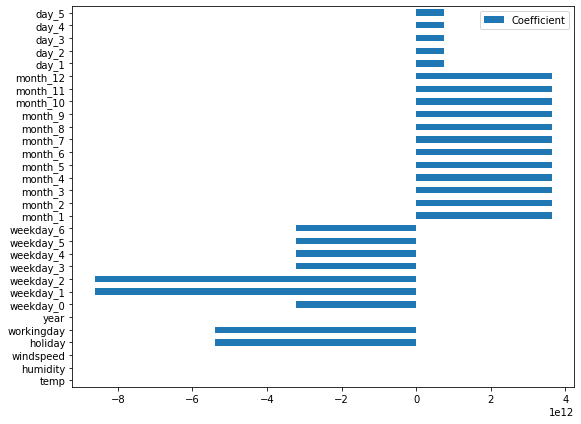

In [2756]:
coeff.plot(kind="barh", figsize=(9, 7))

In [2757]:
#Test
y_pred = lr.predict(X_test)
actual_predicted_lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

## Vorhergesagte und tatsächliche anzahl an Ausleihungen

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

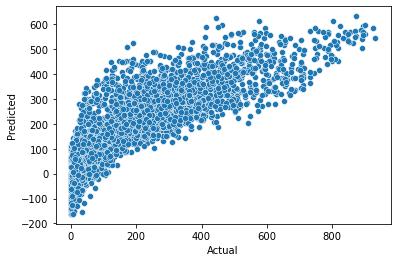

In [2758]:
sns.scatterplot(data=actual_predicted_lr, x="Actual", y="Predicted")

## Häufigkeitsverteilung der vorhersagen bei Linearer Regression

[Text(0.5, 0, 'count'), Text(0, 0.5, 'frequency')]

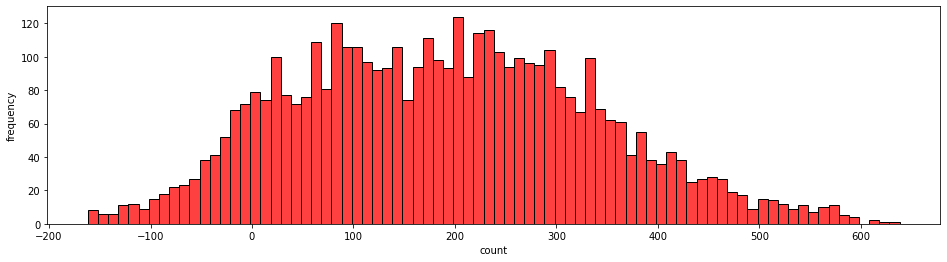

In [2759]:

plt.figure(figsize = (16,4))
ax = sns.histplot(data=y_pred,  binwidth=10, color="red")
ax.set(xlabel='count', ylabel='frequency')


## Häufigkeitsverteilung der gesammelten Daten

[Text(0.5, 0, 'count'), Text(0, 0.5, 'frequency')]

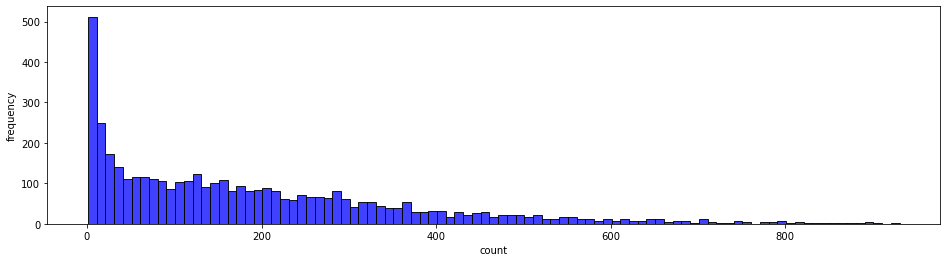

In [2760]:
plt.figure(figsize = (16,4))
ax = sns.histplot(data=y_test,  binwidth=10, color="blue")
ax.set(xlabel='count', ylabel='frequency')

In [2761]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred),'Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Squared Error: 9800.247564906183 Mean Absolute Error: 72.88080683413739


# Test Ridge Regression

In [2762]:
from sklearn.linear_model import Ridge

temp_mse = 99999.9
for i in np.linspace(0, 20, 60):
    rr = Ridge(alpha= i, normalize=True)
    rr.fit(X_train, y_train)
    rr_pred = rr.predict(X_test)

    mse = metrics.mean_squared_error(y_test, rr_pred)
    #print('Mean Squared Error:', mse)
    if(mse < temp_mse):
        temp_mse = mse
print('Mean Squared Error:', temp_mse)

Mean Squared Error: 9800.278105090078


In [2763]:
from sklearn.linear_model import Lasso

temp_mse = 99999.9
for i in np.logspace(-10, -1, 90):
    lassor = Ridge(alpha= i, normalize=True, tol = 0.1)
    lassor.fit(X_train, y_train)
    lassor_pred = lassor.predict(X_test)

    mse = metrics.mean_squared_error(y_test, rr_pred)
    #print('Mean Squared Error:', mse)
    if(mse < temp_mse):
        temp_mse = mse
print('Mean Squared Error:', temp_mse)

Mean Squared Error: 28924.5094072632


# Test Random Forrest Regressor

In [2764]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

mse = metrics.mean_squared_error(y_test, rfr_pred)
print('Mean Squared Error:', mse,'Mean Absolute Error:', metrics.mean_absolute_error(y_test, rfr_pred))

actual_predicted_rfr = pd.DataFrame({'Actual': y_test, 'Predicted': rfr_pred})


Mean Squared Error: 2092.5204368663594 Mean Absolute Error: 27.701552995391705


## Vorhergesagte und tatsächliche anzahl an Ausleihungen

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

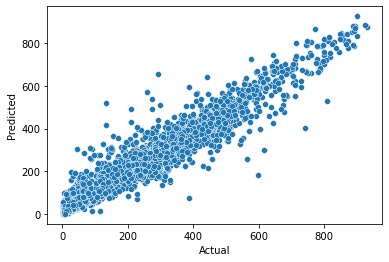

In [2765]:
sns.scatterplot(data=actual_predicted_rfr, x="Actual", y="Predicted")


## Häufigkeitsverteilung der vorhergesagten Werte

[Text(0.5, 0, 'count'), Text(0, 0.5, 'frequency')]

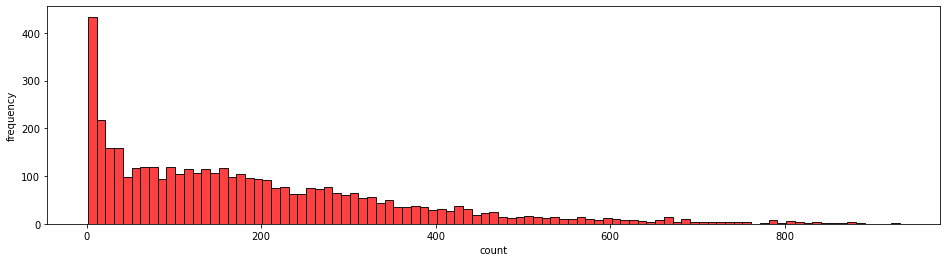

In [2766]:
plt.figure(figsize = (16,4))
ax = sns.histplot(data=rfr_pred,  binwidth=10, color="red")
ax.set(xlabel='count', ylabel='frequency')

# Interactive Forecast

## Definition der vorhezusagenden Daten

In [2767]:
forecast_predict = pd.DataFrame({
    'datetime':[
        '2021-11-18 08:00:00',
    ],
    'temp':[
        '6.8',
    ],
    'humidity':[
        '91.0'
    ],
    'windspeed':[
        '4.2'
    ],
    'holiday':[
        '0.0'
    ],
    'workingday':[
        '1.0',
    ],
})
forecast_predict['datetime'] = pd.to_datetime(forecast_predict['datetime'])

forecast_predict = forecast_predict.set_index('datetime')
augmented_forecast_predict = augment_date_information(forecast_predict)

#print(augmented_forecast_predict)
#encoder shapes data in form of the trained data
forecast_predict = encoder.transform(augmented_forecast_predict)



## Vorhersage wie viele Scooter zwischen 8 und 9 Uhr ausgeliehen werden

In [2768]:
print(rfr.predict(forecast_predict)[0])

145.79
